# Scipy Iterative Solvers Performance

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg
import scipy.optimize
import matplotlib.pylab as plt
import pandas as pd
import time

## Build Functions

In [2]:
def buildA(N):
    dx = 1 / N
    nvar = (N - 1)**2
    e1 = np.ones((nvar), dtype=float)
    e2 = np.copy(e1)
    e2[::N-1] = 0
    e3 = np.copy(e1)
    e3[N-2::N-1] = 0
    A = sp.spdiags(
        (-e1, -e3, 4*e1, -e2, -e1),
        (-(N-1), -1, 0, 1, N-1), nvar, nvar
    )
    A = A / dx**2
    return A

In [3]:
def buildf1(N):
    x = np.arange(0, 1, 1/N).reshape(N, 1)
    y = x.T
    f = np.dot(np.sin(np.pi*x), np.sin(np.pi*y))
    return f[1:,1:].reshape(-1,1)

In [4]:
def buildf2(N):
    x = np.arange(0, 1, 1/N).reshape(N, 1)
    y = x.T
    f = np.dot(np.maximum(x,1-x), np.maximum(y,1-y))
    return f[1:,1:].reshape(-1, 1)

## Setup Dataframe

In [5]:
cols = ['inv', 'LU', 'Cholesky', 'CG', 'BiCGSTAB', 'GMRES']
iter_cols = ['CG', 'BiCGSTAB', 'GMRES']
Ns = np.logspace(0.5, 2.0, 20, dtype=int)
Ns = np.unique(Ns)
perf_data_1 = pd.DataFrame(columns=cols, index=Ns).rename_axis('N')
perf_data_2 = pd.DataFrame(columns=cols, index=Ns).rename_axis('N')
iter_data_1 = pd.DataFrame(columns=iter_cols, index=Ns).rename_axis('N')
iter_data_2 = pd.DataFrame(columns=iter_cols, index=Ns).rename_axis('N')

## Solve using scipy.linalg.inv

In [6]:
for j, (buildf, perf_data) in enumerate(zip((buildf1, buildf2), (perf_data_1, perf_data_2))):
    for N in Ns:
        print('                             ', end='\r')
        print(f'Solving j={j}, N={N}', end='\r')
        if N > 64:
            continue
        A = buildA(N)
        f = buildf(N)

        t0 = time.perf_counter()
        invA = scipy.linalg.inv(A.toarray())
        x = invA @ f
        t1 = time.perf_counter()
        perf_data.loc[N].inv = t1-t0
        np.testing.assert_almost_equal(A@x, f)


## Solve Using LU and Cholesky Decomposition

In [7]:
for j, (buildf, perf_data) in enumerate(zip((buildf1, buildf2), (perf_data_1, perf_data_2))):
    for N in Ns:
        print('                             ', end='\r')
        print(f'Solving j={j}, N={N}', end='\r')
        A = buildA(N)
        Adense = A.toarray()
        f = buildf(N)

        t0 = time.perf_counter()
        lu_A = scipy.linalg.lu_factor(Adense)
        x_lu = scipy.linalg.lu_solve(lu_A, f)
        t1 = time.perf_counter()
        perf_data.loc[N].LU = t1-t0
        np.testing.assert_almost_equal(A@x_lu, f)

        t0 = time.perf_counter()
        cho_A = scipy.linalg.cho_factor(Adense)
        x_cho = scipy.linalg.cho_solve(cho_A, f)
        t1 = time.perf_counter()
        perf_data.loc[N].Cholesky = t1-t0
        np.testing.assert_almost_equal(A@x_cho, f)

        np.testing.assert_almost_equal(x_lu, x_cho)

## Solve using CG

In [8]:
global iters
def callback(x):
    global iters
    iters += 1

for j, (buildf, perf_data, iter_data) in enumerate(zip((buildf1, buildf2), (perf_data_1, perf_data_2), (iter_data_1, iter_data_2))):
    for N in Ns:
        print('                             ', end='\r')
        print(f'Solving j={j}, N={N}', end='\r')
        A = buildA(N)
        f = buildf(N)

        iters = 0
        t0 = time.perf_counter()
        x_cg, info = sp.linalg.cg(A, f, callback=callback)
        t1 = time.perf_counter()
        perf_data.loc[N].CG = t1-t0
        iter_data.loc[N].CG = iters
        np.testing.assert_almost_equal(A@x_cg.reshape(-1, 1), f, decimal=3)

## Solve using BiCGSTAB and GMRES

In [9]:
global iters
def callback(x):
    global iters
    iters += 1

for j, (buildf, perf_data, iter_data) in enumerate(zip((buildf1, buildf2), (perf_data_1, perf_data_2), (iter_data_1, iter_data_2))):
    for N in Ns:
        print('                             ', end='\r')
        print(f'Solving j={j}, N={N}', end='\r')
        A = buildA(N)
        f = buildf(N)

        iters = 0
        t0 = time.perf_counter()
        x_bicgstab, info = sp.linalg.bicgstab(A, f, callback=callback)
        t1 = time.perf_counter()
        perf_data.loc[N].BiCGSTAB = t1-t0
        iter_data.loc[N].BiCGSTAB = iters
        np.testing.assert_almost_equal(A@x_bicgstab.reshape(-1, 1), f, decimal=3)

        iters = 0
        t0 = time.perf_counter()
        x_gmres, info = sp.linalg.gmres(A, f, callback=callback)
        t1 = time.perf_counter()
        perf_data.loc[N].GMRES = t1-t0
        iter_data.loc[N].GMRES = iters
        np.testing.assert_almost_equal(A@x_gmres.reshape(-1, 1), f, decimal=3)

## Plot Results

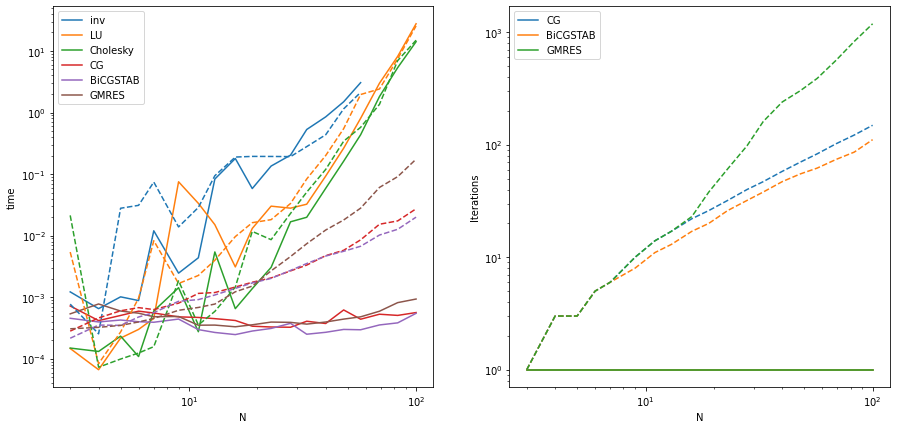

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].loglog(Ns, perf_data_1, ls='-')
axs[0].set_prop_cycle(None)
axs[0].loglog(Ns, perf_data_2, ls='--')
axs[0].legend(cols)
axs[0].set_xlabel('N')
axs[0].set_ylabel('time')

axs[1].loglog(Ns, iter_data_1, ls='-')
axs[1].set_prop_cycle(None)
axs[1].loglog(Ns, iter_data_2, ls='--')
axs[1].legend(iter_cols)
axs[1].set_xlabel('N')
axs[1].set_ylabel('Iterations')
plt.show()